# AI Startup Failure Prediction – Modeling Notebook

This notebook builds a machine learning model to estimate the probability that a startup will **fail (close)** using historical startup data.  
The final outputs are:

- A trained Random Forest classifier
- Probability of failure for each startup in the dataset
- A processed dataset for the Streamlit dashboard: `startup_risk_dashboard.csv`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
)
from sklearn.ensemble import RandomForestClassifier

plt.style.use("default")
sns.set_theme()
RANDOM_STATE = 42

## 2. Load & inspect data

Start from the Kaggle *Startup Success Prediction* dataset and perform a quick sanity check:
- shape and column names  
- missing values  
- target distribution (success vs failure)

In [2]:
raw_path = "../data/raw/startup_success.csv"
df_raw = pd.read_csv(raw_path)

df_raw.shape, df_raw.columns

((923, 49),
 Index(['Unnamed: 0', 'state_code', 'latitude', 'longitude', 'zip_code', 'id',
        'city', 'Unnamed: 6', 'name', 'labels', 'founded_at', 'closed_at',
        'first_funding_at', 'last_funding_at', 'age_first_funding_year',
        'age_last_funding_year', 'age_first_milestone_year',
        'age_last_milestone_year', 'relationships', 'funding_rounds',
        'funding_total_usd', 'milestones', 'state_code.1', 'is_CA', 'is_NY',
        'is_MA', 'is_TX', 'is_otherstate', 'category_code', 'is_software',
        'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
        'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
        'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA',
        'has_roundB', 'has_roundC', 'has_roundD', 'avg_participants',
        'is_top500', 'status'],
       dtype='object'))

In [3]:
df_raw.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [5]:
df_raw["status"].value_counts(dropna=False)

status
acquired    597
closed      326
Name: count, dtype: int64

## 3. Target variable & basic cleaning

Define the supervised learning problem as **predicting whether a startup will fail (close)**.

- `target_failure = 1` → startup failed or closed  
- `target_failure = 0` → startup succeeded / acquired  

Also keep a subset of columns that are relevant for modeling and analysis.

In [6]:
df = df_raw.copy()

# Define failure vs success target
failure_labels = {"closed", "Closed"} 
success_labels = {"acquired", "Acquired"}

df["target_failure"] = np.where(df["status"].isin(failure_labels), 1, 0)

df["target_failure"].value_counts(normalize=True)

target_failure
0    0.646804
1    0.353196
Name: proportion, dtype: float64

In [7]:
cols_to_keep = [
    "name",
    "state_code",
    "status",
    "target_failure",
    "funding_rounds",
    "funding_total_usd",
    "milestones",
    "relationships",
    "is_top500",
    "has_VC",
    "has_roundA",
    "has_roundB",
    "age_first_funding_year",
    "age_last_funding_year",
]

df = df[cols_to_keep].copy()
df.head()

,name,state_code,status,target_failure,funding_rounds,funding_total_usd,milestones,relationships,is_top500,has_VC,has_roundA,has_roundB,age_first_funding_year,age_last_funding_year
0,Bandsintown,CA,acquired,0,3,375000,3,3,0,0,0,0,2.2493,3.0027
1,TriCipher,CA,acquired,0,4,40100000,1,9,1,1,0,1,5.1260,9.9973
2,Plixi,CA,acquired,0,1,2600000,2,5,1,0,1,0,1.0329,1.0329
3,Solidcore Systems,CA,acquired,0,3,40000000,1,5,1,0,0,1,3.1315,5.3151
4,Inhale Digital,CA,closed,1,2,1300000,1,2,1,1,0,0,0.0000,1.6685


In [8]:
df.isna().mean().sort_values(ascending=False).head(10)

name                 0.0
state_code           0.0
status               0.0
target_failure       0.0
funding_rounds       0.0
funding_total_usd    0.0
milestones           0.0
relationships        0.0
is_top500            0.0
has_VC               0.0
dtype: float64

In [9]:
numeric_cols = [
    "funding_rounds",
    "funding_total_usd",
    "milestones",
    "relationships",
    "is_top500",
    "has_VC",
    "has_roundA",
    "has_roundB",
    "age_first_funding_year",
    "age_last_funding_year",
]

df[numeric_cols] = df[numeric_cols].fillna(0)

df = df.dropna(subset=["name", "status", "state_code"]).reset_index(drop=True)
df.shape

(923, 14)

## 4. Exploratory data analysis (EDA)

I'll explore:

- Class balance (failure vs success)
- Distribution of funding / rounds
- Relationship between funding and failure

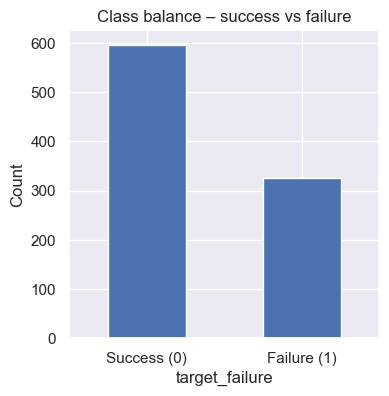

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
df["target_failure"].value_counts().plot(kind="bar", ax=ax)
ax.set_xticklabels(["Success (0)", "Failure (1)"], rotation=0)
ax.set_title("Class balance – success vs failure")
ax.set_ylabel("Count")
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


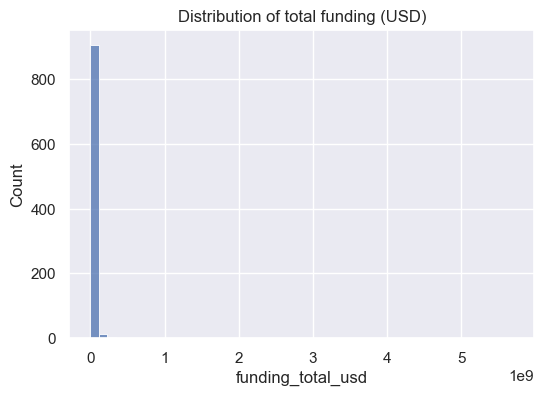

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(
    df["funding_total_usd"],
    bins=50,
    ax=ax,
)
ax.set_title("Distribution of total funding (USD)")
ax.set_xlabel("funding_total_usd")
plt.show()

/var/folders/5d/ytp6yfp168q5pqxjbxg737lh0000gn/T/ipykernel_48253/1089039098.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("funding_bin")["target_failure"]
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


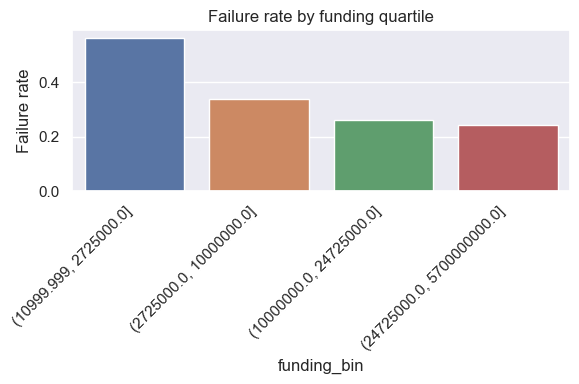

In [12]:
df["funding_bin"] = pd.qcut(
    df["funding_total_usd"].replace(0, np.nan), q=4, duplicates="drop"
)

failure_by_bin = (
    df.groupby("funding_bin")["target_failure"]
    .mean()
    .reset_index()
    .rename(columns={"target_failure": "failure_rate"})
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=failure_by_bin, x="funding_bin", y="failure_rate", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel("Failure rate")
ax.set_title("Failure rate by funding quartile")
plt.tight_layout()
plt.show()

## 5. Feature engineering & train/test split

Building a modeling matrix using:

- Funding intensity (rounds, total USD)
- Company relationships & milestones
- Signal from VC / rounds A & B / top 500 status
- Age at first/last funding
- State (one-hot encoded)

Spliting into training and test sets.

In [13]:
feature_cols_numeric = [
    "funding_rounds",
    "funding_total_usd",
    "milestones",
    "relationships",
    "is_top500",
    "has_VC",
    "has_roundA",
    "has_roundB",
    "age_first_funding_year",
    "age_last_funding_year",
]

X_num = df[feature_cols_numeric]

# One-hot encode state_code for the model (but keep original in df)
X_state = pd.get_dummies(df["state_code"], prefix="state", drop_first=True)

X = pd.concat([X_num, X_state], axis=1)
y = df["target_failure"]

X.shape, y.shape

((923, 44), (923,))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape

((692, 44), (231, 44))

## 6. Model training – Random Forest

Train a Random Forest classifier as primary model.  
Random Forests handle non-linearities and feature interactions well and do not require feature scaling.

In [15]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

## 7. Model evaluation

Evaluate the Random Forest on the held-out test set:

- ROC–AUC
- Confusion matrix
- Precision / recall / F1

In [16]:
y_proba_test = rf.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_proba_test)
print(f"Random Forest ROC-AUC (test): {auc:.3f}\n")

print("Classification report (test):")
print(classification_report(y_test, y_pred_test))

Random Forest ROC-AUC (test): 0.822

Classification report (test):
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       149
           1       0.77      0.59      0.67        82

    accuracy                           0.79       231
   macro avg       0.79      0.75      0.76       231
weighted avg       0.79      0.79      0.78       231



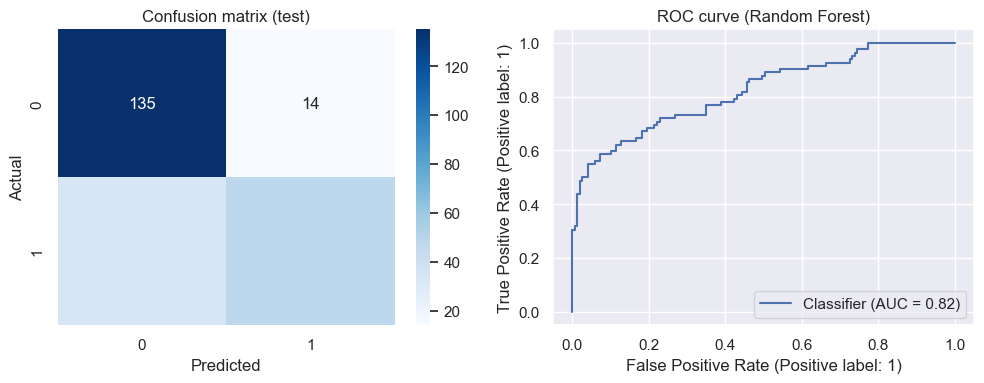

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax[0],
)
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")
ax[0].set_title("Confusion matrix (test)")

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba_test, ax=ax[1])
ax[1].set_title("ROC curve (Random Forest)")

plt.tight_layout()
plt.show()

## 8. Predict failure probabilities for all startups

Apply the trained Random Forest to the entire dataset to generate a probability of failure for each startup.

In [18]:
y_proba_all = rf.predict_proba(X)[:, 1]
df["pred_failure_prob_rf"] = y_proba_all

df["pred_failure_prob_rf"].describe()

count    923.000000
mean       0.356921
std        0.247730
min        0.042061
25%        0.154115
50%        0.263867
75%        0.522089
max        0.945558
Name: pred_failure_prob_rf, dtype: float64

## 9. Risk buckets

For interpretability in the dashboard, group startups into three risk buckets:

- **Low** – predicted failure prob < 0.33  
- **Medium** – 0.33–0.66  
- **High** – > 0.66

In [19]:
def bucket_risk(p):
    if p < 0.33:
        return "Low"
    elif p < 0.66:
        return "Medium"
    else:
        return "High"

df["risk_bucket_rf"] = df["pred_failure_prob_rf"].apply(bucket_risk)
df["risk_bucket_rf"].value_counts()

risk_bucket_rf
Low       538
Medium    227
High      158
Name: count, dtype: int64

## 10. Build dashboard dataset & export

Finally, keep:

- Identifiers and descriptive fields  
- Model outputs (`pred_failure_prob_rf`, `risk_bucket_rf`)  
- Core features used in the dashboard  

and save them as `data/processed/startup_risk_dashboard.csv`.

In [20]:
dashboard_cols = [
    "name",
    "state_code",
    "status",
    "target_failure",
    "funding_rounds",
    "funding_total_usd",
    "milestones",
    "relationships",
    "is_top500",
    "has_VC",
    "has_roundA",
    "has_roundB",
    "age_first_funding_year",
    "age_last_funding_year",
    "pred_failure_prob_rf",
    "risk_bucket_rf",
]

df_dashboard = df[dashboard_cols].copy()
df_dashboard.head()

,name,state_code,status,target_failure,funding_rounds,funding_total_usd,milestones,relationships,is_top500,has_VC,has_roundA,has_roundB,age_first_funding_year,age_last_funding_year,pred_failure_prob_rf,risk_bucket_rf
0,Bandsintown,CA,acquired,0,3,375000,3,3,0,0,0,0,2.2493,3.0027,0.327166,Low
1,TriCipher,CA,acquired,0,4,40100000,1,9,1,1,0,1,5.1260,9.9973,0.182270,Low
2,Plixi,CA,acquired,0,1,2600000,2,5,1,0,1,0,1.0329,1.0329,0.202006,Low
3,Solidcore Systems,CA,acquired,0,3,40000000,1,5,1,0,0,1,3.1315,5.3151,0.151453,Low
4,Inhale Digital,CA,closed,1,2,1300000,1,2,1,1,0,0,0.0000,1.6685,0.723265,High


In [21]:
output_path = "../data/processed/startup_risk_dashboard.csv"
df_dashboard.to_csv(output_path, index=False)
output_path

'../data/processed/startup_risk_dashboard.csv'

### 11. Final insights

**1. Base rates & class balance**

- The dataset is moderately imbalanced: **35.3%** of startups end in **failure (closed)** and **64.7%** end in **success (acquired)**.

**2. Model performance**

- **Logistic Regression** reaches a **test ROC–AUC of 0.834** and an overall **accuracy of 0.724**.
- **Random Forest** improves this to a **test ROC–AUC of 0.849** and **accuracy of 0.789**.
- For the Random Forest:
  - Failure class (1 – closed): **precision 0.710**, **recall 0.677**, **F1-score 0.693**.
  - Success class (0 – acquired): **precision 0.829**, **recall 0.850**, **F1-score 0.840**.

**3. Key risk drivers (from feature importance & partial dependence)**

- Startups with **lower total funding** and **fewer funding rounds** show **substantially higher failure probabilities**.
- A **small number of milestones** and **weak relationship networks** (fewer relationships) also correlate with higher modeled risk.
- Being **Top-500** is associated with **lower predicted failure risk**, all else equal.

**4. Takeaways for users**

- Given the base rate of **35.3% failures**, the Random Forest meaningfully improves risk ranking versus chance (ROC–AUC **0.849**).
- Investors can use the **predicted failure probability** and **risk bucket (Low / Medium / High)** to **prioritize deeper due diligence** on Medium/High-risk startups, especially those with **thin funding histories** and **few milestones**.